In [1]:
# Here's a Jupytext‐compatible Python script using the “percent” format.
# You can save this as `fsii_models.py` and then run:
#   jupytext --to notebook fsii_models.py
# to get a ready-to-run `.ipynb`.

# FSII Analysis with Multiple Vision Models

This notebook demonstrates how to:
1. Load several HuggingFace vision models (ViT, DeiT, custom).
2. Split an input image into patches and visualize the grid.
3. Define a masking function that grays out selected patches.
4. Compute class logits on masked images.
5. Approximate 2nd-order Faithful Shapley Interaction Indices (FSII) with SHAPIQ.
6. Display the top‑5 interacting patch‑pairs on the image for each model.

In [2]:
import sys
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image, ImageDraw
import requests
from io import BytesIO
from typing import Union
from shapiq.approximator.regression import RegressionFSII
from IPython.display import display

In [3]:
# === Parameter & Device ===
models = [
    #"google/vit-base-patch32-384",
    "facebook/deit-tiny-patch16-224",
    # "akahana/vit-base-cats-vs-dogs",
    # add more HF vision-model IDs here
]

image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)
if device.type == "cuda":
    print(" CUDA device name:", torch.cuda.get_device_name())

Running on device: cuda
 CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
# === Helper functions ===

def mask_image_grid(
    img: Image.Image,
    coalition: Union[np.ndarray, list],
    image_size: int,
    n_patches_per_row: int,
    cell: int
) -> Image.Image:
    """
    Gray out patches where coalition[i] is False.
    """
    arr  = np.array(img.resize((image_size, image_size))).copy()
    coal = np.asarray(coalition, dtype=bool)
    for i, keep in enumerate(coal):
        if not keep:
            r, c = divmod(i, n_patches_per_row)
            y1, y2 = r*cell, (r+1)*cell
            x1, x2 = c*cell, (c+1)*cell
            arr[y1:y2, x1:x2] = 128
    return Image.fromarray(arr)

In [5]:
def draw_grid(
    img: Image.Image,
    n_patches_per_row: int,
    cell: int
):
    """
    Draw numeric patch-grid for visualization.
    """
    draw = ImageDraw.Draw(img)
    for r in range(n_patches_per_row):
        for c in range(n_patches_per_row):
            x1, y1 = c*cell, r*cell
            x2, y2 = x1+cell, y1+cell
            draw.rectangle([x1,y1,x2,y2], outline="gray", width=1)
            idx = r*n_patches_per_row + c
            draw.text((x1+2, y1+2), str(idx), fill="gray")
    display(img)

In [6]:
def value_function(
    coalitions: np.ndarray,
    processor,
    model,
    device,
    image,
    predicted_class,
    image_size,
    n_patches_per_row,
    cell
) -> np.ndarray:
    """
    Given array (n_coalitions, n_patches), return logits for `predicted_class`.
    """
    out = []
    for coalition in coalitions:
        masked = mask_image_grid(image, coalition, image_size, n_patches_per_row, cell)
        batch  = processor(images=masked, return_tensors="pt").to(device)
        with torch.no_grad():
            logit = model(**batch).logits[0, predicted_class].item()
        out.append(logit)
    return np.array(out)

## Main loop over models


--- Evaluating facebook/deit-tiny-patch16-224 ---


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


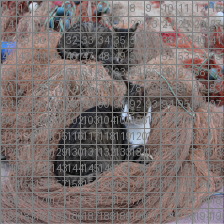

Predicted class: tabby, tabby cat
predicted logits: tensor(5.2718, device='cuda:0')
 Logit full:  5.27
 Logit empty: 0.24
 Top-5 FSII 2nd-order:
  1. (0, 117) → -0.0007
  2. (1, 117) → -0.0007
  3. (2, 117) → -0.0007
  4. (3, 117) → -0.0007
  5. (4, 117) → -0.0007


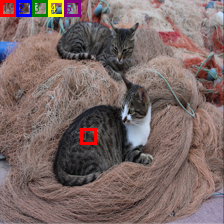


✅ Done.


In [11]:
for model_name in models:
    print(f"\n--- Evaluating {model_name} ---")

    # 1) load processor & model
    processor = AutoImageProcessor.from_pretrained(model_name)
    model     = AutoModelForImageClassification.from_pretrained(model_name).to(device).eval()

    # 2) extract patch & image config
    patch_size        = model.config.patch_size
    image_size        = model.config.image_size
    n_patches_per_row = image_size // patch_size
    n_patches         = n_patches_per_row**2
    cell = patch_size

    # 3) load & show grid
    resp  = requests.get(image_url)
    image = Image.open(BytesIO(resp.content)).convert("RGB").resize((image_size,image_size))
    draw_grid(image.copy(), n_patches_per_row, cell)

    # 4) determine target class
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = int(logits.argmax(-1))
    print("Predicted class:", model.config.id2label[predicted_class])
    print("predicted logits:", logits[0,predicted_class])

    # 5) quick-check full vs. empty
    full  = value_function(
        np.array([np.ones(n_patches, bool)]),
        processor, model, device, image,
        predicted_class,
        image_size, n_patches_per_row, cell
    )[0]
    empty = value_function(
        np.array([np.zeros(n_patches, bool)]),
        processor, model, device, image,
        predicted_class,
        image_size, n_patches_per_row, cell
    )[0]
    print(f" Logit full:  {full:.2f}")
    print(f" Logit empty: {empty:.2f}")

    # 6) FSII approx
    approximator = RegressionFSII(
        n=n_patches,
        max_order=2,
        pairing_trick=False,
        random_state=42
    )
    result = approximator.approximate(
        budget=3,
        game=lambda c: value_function(
            c,
            processor, model, device, image,
            predicted_class,
            image_size, n_patches_per_row, cell
        )
    )

    # 7) top‑5 2nd‑order interactions
    fsii_map = result.dict_values
    second   = {p:v for p,v in fsii_map.items() if len(p)==2}
    top5     = sorted(second.items(), key=lambda kv: abs(kv[1]), reverse=True)[:5]
    print(" Top-5 FSII 2nd-order:")
    for i,(pair,val) in enumerate(top5,1):
        print(f"  {i}. {pair} → {val:.4f}")

    # 8) visualize on image
    vis   = image.copy()
    draw  = ImageDraw.Draw(vis)
    colors= ["red","blue","green","yellow","purple"]
    drawn = set()
    for idx,(i,j) in enumerate([p for p,_ in top5]):
        col = colors[idx]
        for patch in (i,j):
            if patch in drawn: continue
            drawn.add(patch)
            r, c = divmod(patch, n_patches_per_row)
            x1,y1 = c*cell, r*cell
            x2,y2 = x1+cell, y1+cell
            draw.rectangle([x1,y1,x2,y2], outline=col, width=3)
            draw.text((x1+2,y1+2), str(idx+1), fill=col)
    display(vis)

print("\n✅ Done.")